## Visualização dos dados - interativos

Nesse notebook são feitos os protótipos da visualizações interativas dos dados

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.ticker as mtick
from utils.save_csv import save_csv
from utils.load_csv import load_csv
from utils.load_shp import load_shp
from utils.save_graph import save_graph

In [2]:
df_ppa_reg = load_csv("ppa_reg.csv")

gdf_subprefs = load_shp("subprefs.shp")

gdf_merged = load_shp("gdf_merged.shp")

#### Visualização 1

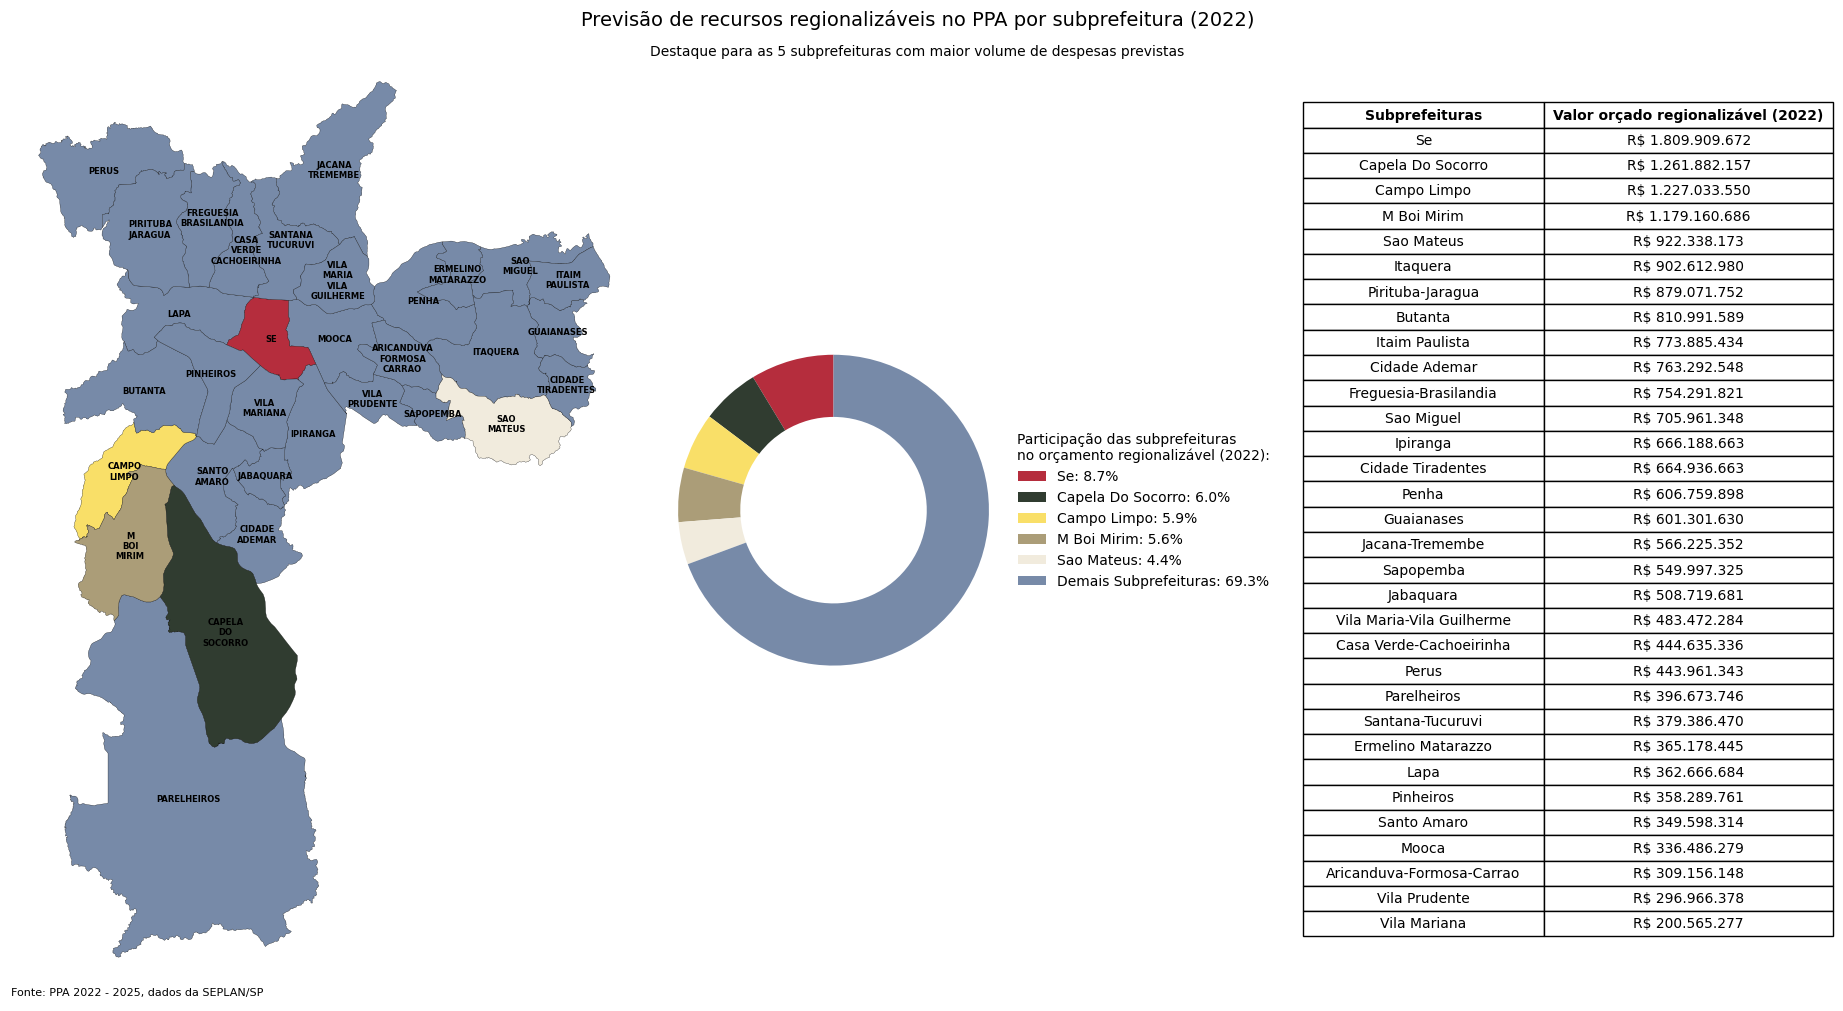

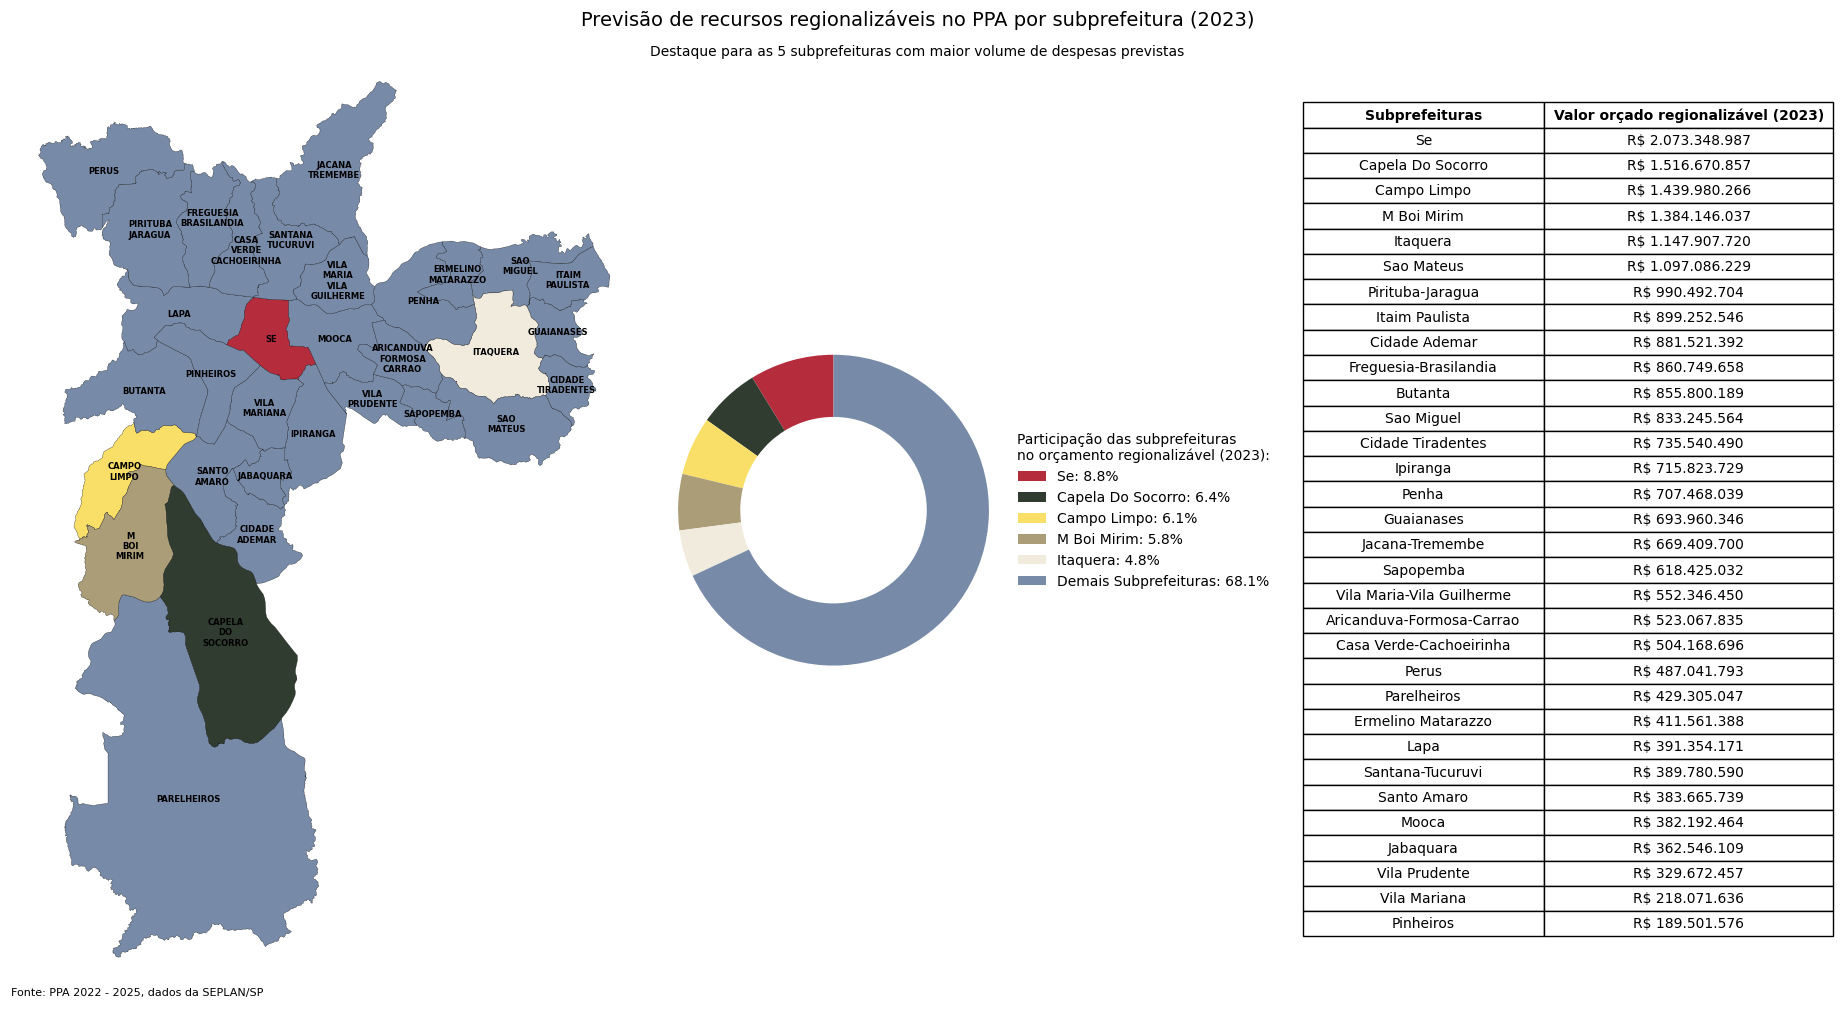

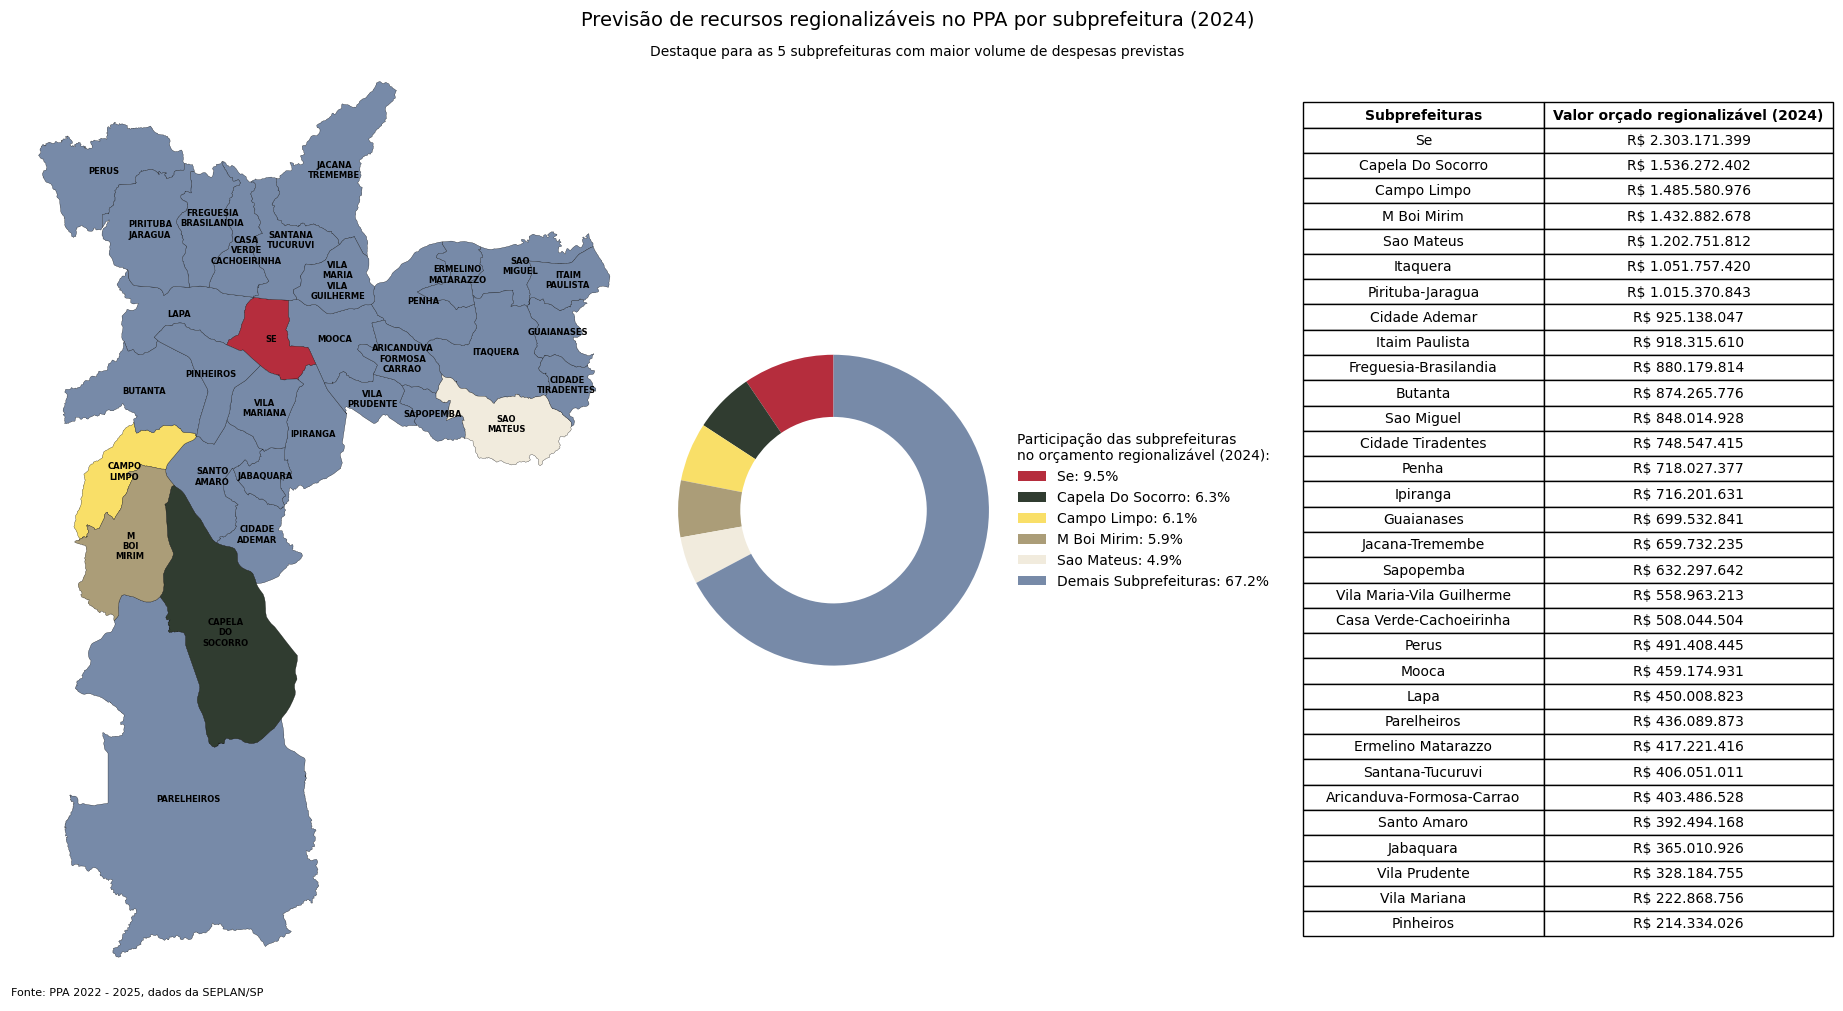

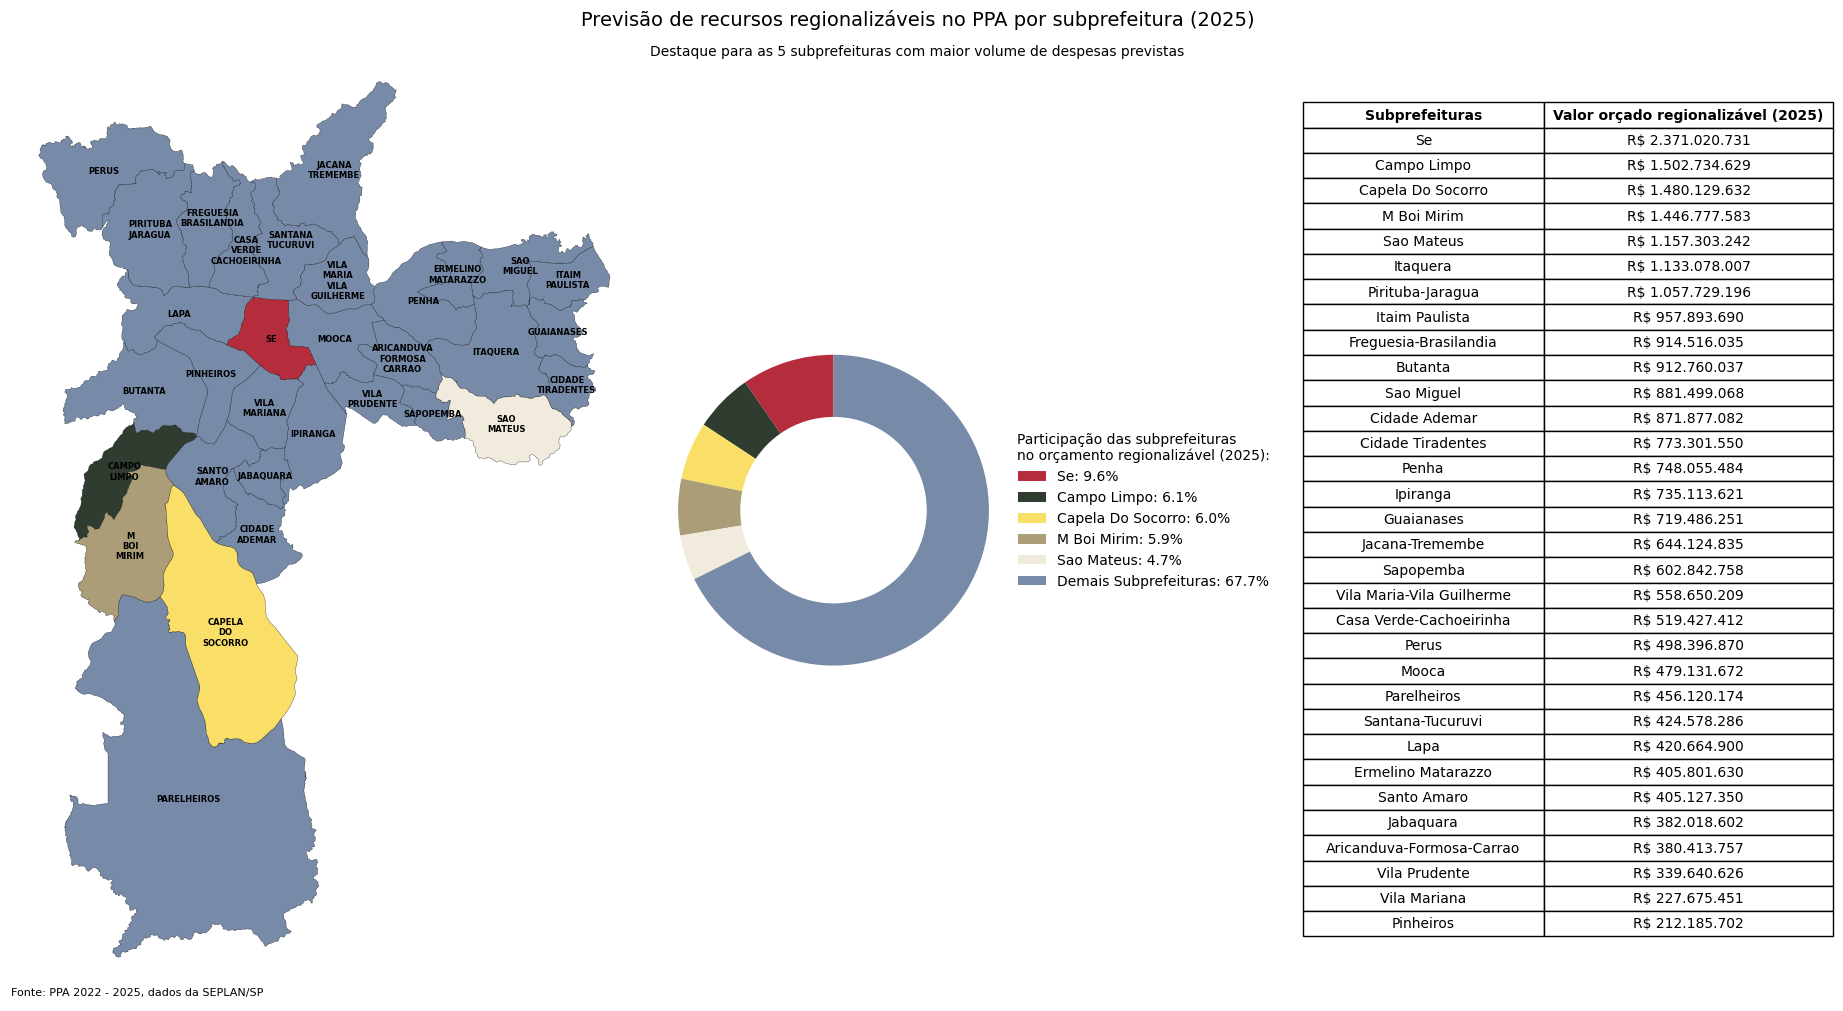

In [3]:
def gerar_interativo1_por_ano(ano):

    df_grouped_mapas = df_ppa_reg.groupby("descricao prefeitura regional")[[f"valor {ano}"]].sum().reset_index()

    gdf_mapa = gdf_subprefs.merge(df_grouped_mapas, 
                                  how = "left", 
                                  left_on = "nm_subpref", 
                                  right_on = "descricao prefeitura regional")

    gdf_mapa["centroid"] = gdf_mapa.geometry.centroid

    deslocamentos = {"FREGUESIA-BRASILANDIA": (500, 500),
                     "CASA VERDE-CACHOEIRINHA": (500, -500),
                     "SANTANA-TUCURUVI": (500, 500)}

    gdf_mapa["desloc_x"] = gdf_mapa.apply(lambda row: row["centroid"].x + deslocamentos.get(row["nm_subpref"], (0, 0))[0], axis = 1)

    gdf_mapa["desloc_y"] = gdf_mapa.apply(lambda row: row["centroid"].y + deslocamentos.get(row["nm_subpref"], (0, 0))[1], axis = 1)

    gdf_mapa["percentual"] = gdf_mapa[f"valor {ano}"] / gdf_mapa[f"valor {ano}"].sum() * 100

    gdf_mapa_sorted = gdf_mapa.sort_values(f"valor {ano}", ascending = False)

    top5 = gdf_mapa_sorted.iloc[:5]

    outros = pd.DataFrame({"nm_subpref": ["Demais subprefeituras"],
                           f"valor {ano}": [gdf_mapa_sorted.iloc[5:][f"valor {ano}"].sum()],
                           "percentual": [gdf_mapa_sorted.iloc[5:][f"valor {ano}"].sum() / gdf_mapa[f"valor {ano}"].sum() * 100]})

    plot_df = pd.concat([top5[["nm_subpref", f"valor {ano}", "percentual"]], outros], ignore_index = True)

    colors = ["#B52D3D", "#303C30", "#F9DF68", "#AB9D78", "#F1EBDD", "#778AA8"]
    #["#d53e4f", "#fc8d59", "#fee08b", "#e6f598", "#99d594", "#3288bd"]
    
    color_map = dict(zip(plot_df["nm_subpref"], colors))

    gdf_mapa["grupo_cor"] = gdf_mapa["nm_subpref"].where(gdf_mapa["nm_subpref"].isin(top5["nm_subpref"]), "Demais subprefeituras")

    gdf_mapa["cor"] = gdf_mapa["grupo_cor"].map(color_map)

    fig, (ax_map, ax_pie, ax_table) = plt.subplots(1, 3, figsize = (20, 10), 
                                                   gridspec_kw = {"width_ratios": [2, 1, 1]}, 
                                                   constrained_layout = True)

    bbox = ax_pie.get_position()

    ax_pie.set_position([bbox.x0 - 0.1, bbox.y0, bbox.width, bbox.height])

    gdf_mapa.plot(color = gdf_mapa["cor"],
                  linewidth = 0.2,
                  edgecolor = "black",
                  ax = ax_map)

    for _, row in gdf_mapa.iterrows():
        nome = "\n".join(row["nm_subpref"].replace("-", " ").split())
        ax_map.text(row["desloc_x"], row["desloc_y"],
                    nome,
                    fontsize = 6,
                    ha = "center",
                    va = "center",
                    fontweight = "bold",
                    color = "black")

    ax_map.axis("off")

    wedges, texts = ax_pie.pie(plot_df[f"valor {ano}"],
                               labels = None,
                               startangle = 90,
                               colors = colors,
                               wedgeprops = dict(width = 0.4))

    legend_labels = [f'{row["nm_subpref"].title()}: {row["percentual"]:.1f}%' for _, row in plot_df.iterrows()]

    legend = ax_pie.legend(wedges, 
                           legend_labels,
                           title = f"Participação das subprefeituras\nno orçamento regionalizável ({ano}):",
                           loc = "center left",
                           bbox_to_anchor = (1, 0.5),
                           fontsize = 10)

    legend.get_frame().set_linewidth(0)

    legend.get_frame().set_facecolor("none")

    ax_pie.axis("equal")

    gdf_mapa_sorted["valor_fmt"] = gdf_mapa_sorted[f"valor {ano}"].apply(lambda x: f"R$ {x:,.0f}".replace(",", "."))

    table_data = []
    for _, row in gdf_mapa_sorted.iterrows():
        nome_formatado = row["nm_subpref"].title()
        table_data.append([nome_formatado, row["valor_fmt"]])

    table_df = pd.DataFrame(table_data, columns=["Subprefeituras", f"Valor orçado regionalizável ({ano})"])

    ax_table.axis("off")
    table = ax_table.table(cellText = table_df.values,
                           colLabels = table_df.columns,
                           cellLoc = "left",
                           colLoc = "left",
                           loc = "center",
                           colWidths = [0.5, 0.6])

    table.auto_set_font_size(False)

    table.set_fontsize(10)
    
    table.scale(1, 1.5)

    for i in range(len(table_df)):
        for j in range(2): 
            table[(i+1, j)].set_facecolor("white")
            table[(i+1, j)].set_text_props(color = "black", fontweight = "normal", ha = "center")

    for j in range(2):
        table[(0, j)].set_text_props(fontweight = "bold", ha = "center")
        table[(0, j)].set_facecolor("white")

    fig.suptitle(f"Previsão de recursos regionalizáveis no PPA por subprefeitura ({ano})", fontsize = 14, x = 0.54)

    fig.text(0.54, 0.95, "Destaque para as 5 subprefeituras com maior volume de despesas previstas", 
             ha = "center", fontsize = 10)

    plt.figtext(0.15, 0.01, "Fonte: PPA 2022 - 2025, dados da SEPLAN/SP", ha = "center", fontsize = 8)

    plt.show()

    save_graph(fig, f"interativo_1_{ano}.png")

for ano in [2022, 2023, 2024, 2025]:
    gerar_interativo1_por_ano(ano)

Separação dos elementos

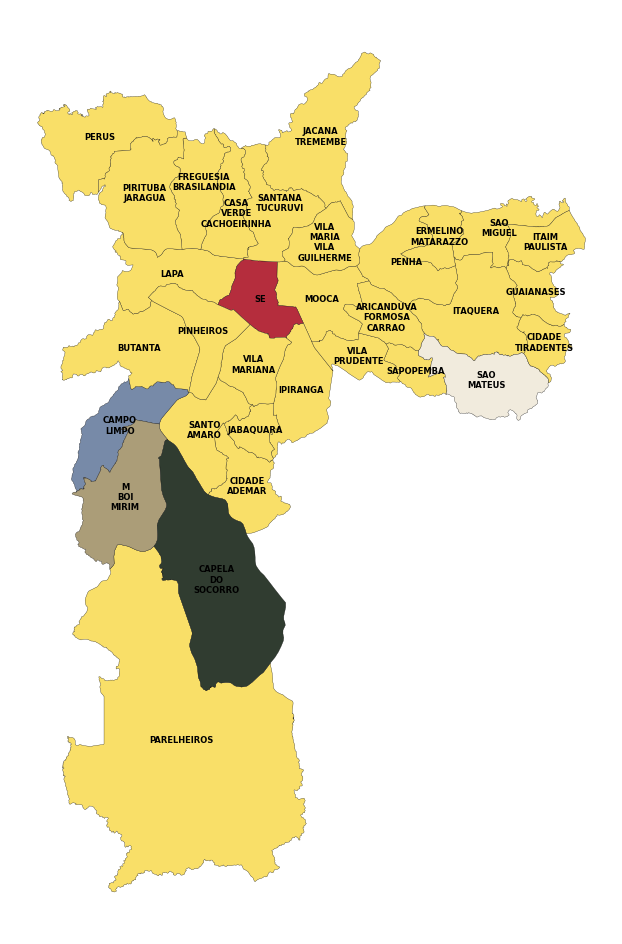

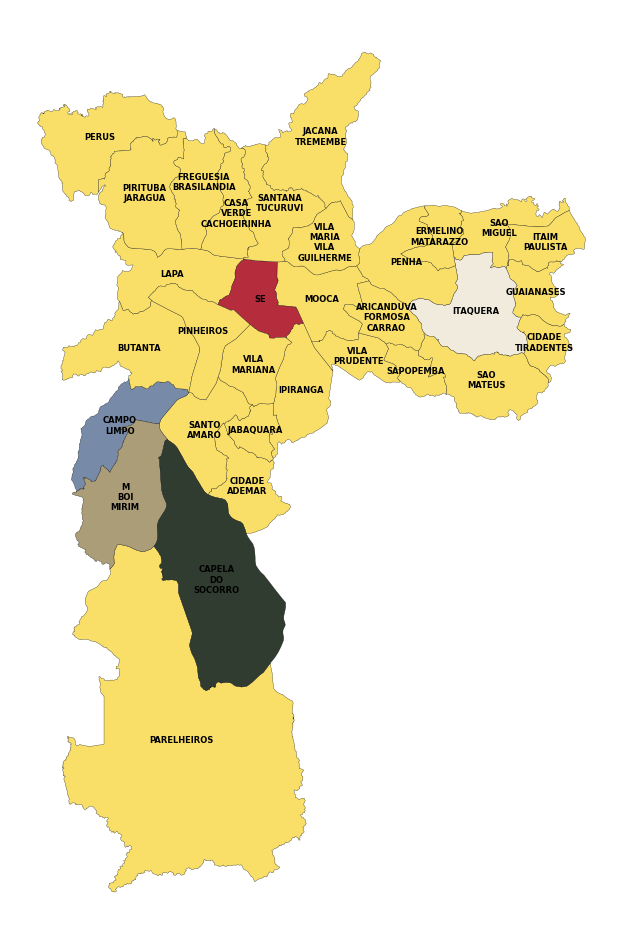

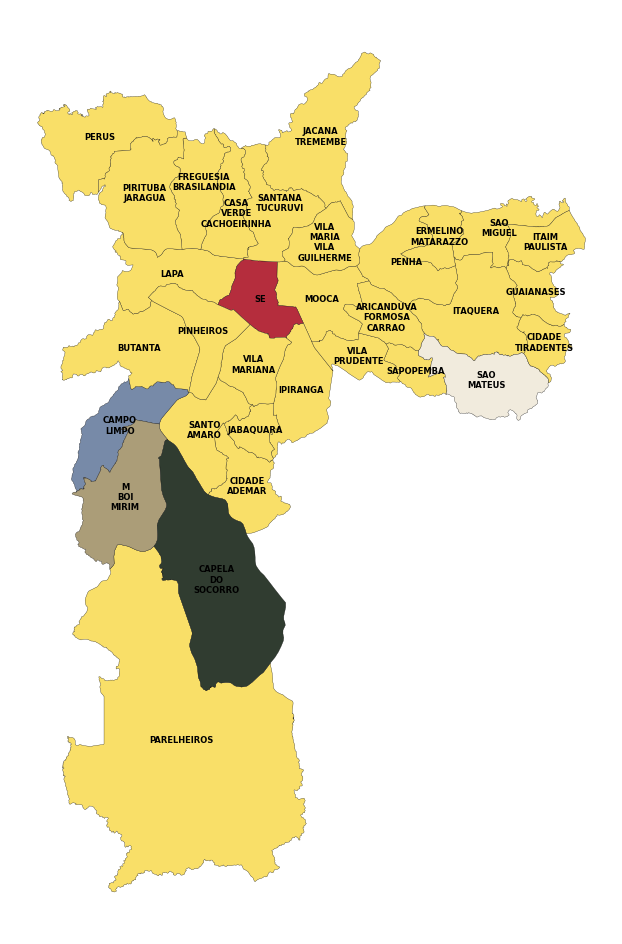

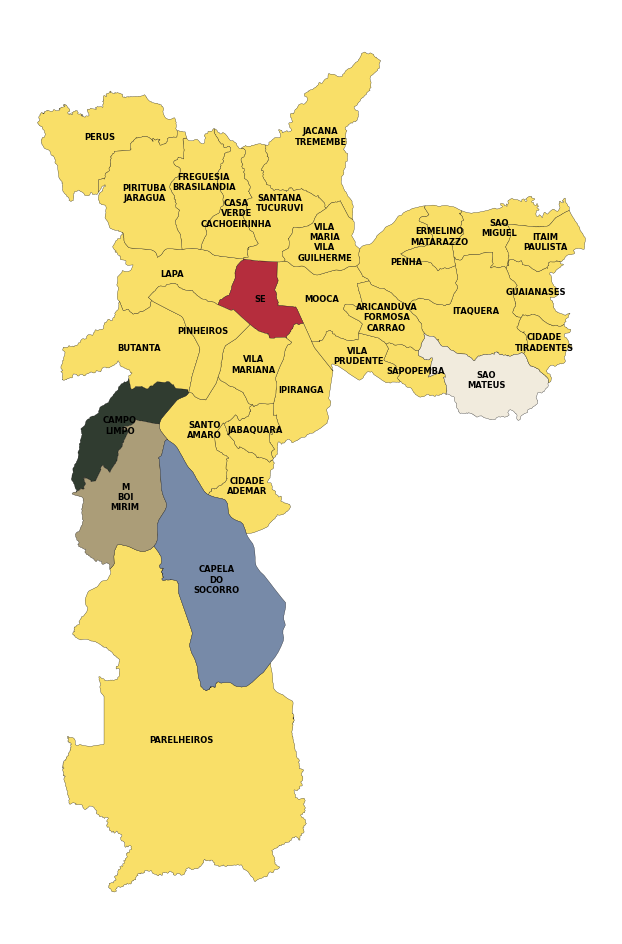

In [4]:
def gerar_mapa_subprefeituras(ano):
    df_grouped = df_ppa_reg.groupby("descricao prefeitura regional")[[f"valor {ano}"]].sum().reset_index()

    gdf_mapa = gdf_subprefs.merge(df_grouped, how="left",
                                  left_on="nm_subpref", right_on="descricao prefeitura regional")

    gdf_mapa["centroid"] = gdf_mapa.geometry.centroid

    deslocamentos = {"FREGUESIA-BRASILANDIA": (500, 500),
                     "CASA VERDE-CACHOEIRINHA": (500, -500),
                     "SANTANA-TUCURUVI": (500, 500)}

    gdf_mapa["desloc_x"] = gdf_mapa.apply(lambda row: row["centroid"].x + deslocamentos.get(row["nm_subpref"], (0, 0))[0], axis=1)
    gdf_mapa["desloc_y"] = gdf_mapa.apply(lambda row: row["centroid"].y + deslocamentos.get(row["nm_subpref"], (0, 0))[1], axis=1)

    top5 = gdf_mapa.sort_values(f"valor {ano}", ascending=False).iloc[:5]["nm_subpref"].tolist()

    gdf_mapa["grupo_cor"] = gdf_mapa["nm_subpref"].where(gdf_mapa["nm_subpref"].isin(top5), "Demais subprefeituras")

    cores = ["#B52D3D", "#303C30", "#778AA8", "#AB9D78", "#F1EBDD", "#F9DF68"]
    cor_map = dict(zip(top5 + ["Demais subprefeituras"], cores))

    gdf_mapa["cor"] = gdf_mapa["grupo_cor"].map(cor_map)

    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    gdf_mapa.plot(color=gdf_mapa["cor"], edgecolor="black", linewidth=0.2, ax=ax)

    for _, row in gdf_mapa.iterrows():
        nome = "\n".join(row["nm_subpref"].replace("-", " ").split())
        ax.text(row["desloc_x"], row["desloc_y"], nome,
                fontsize=6, ha="center", va="center", fontweight="bold")

    ax.axis("off")
    plt.show()

for ano in [2022, 2023, 2024, 2025]:
    gerar_mapa_subprefeituras(ano)

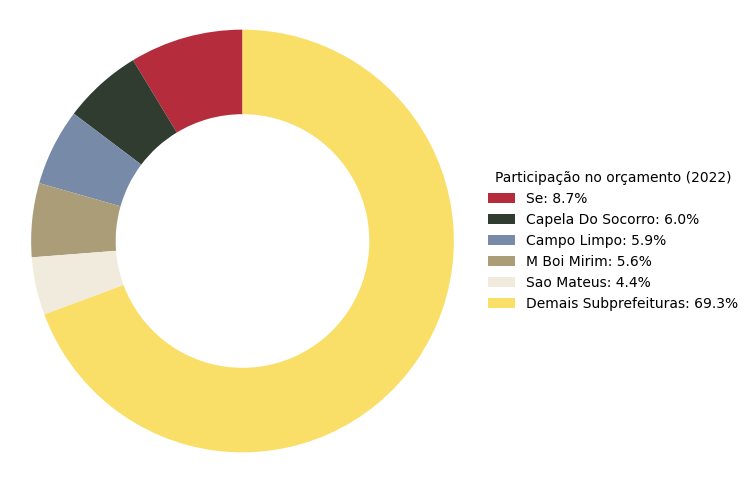

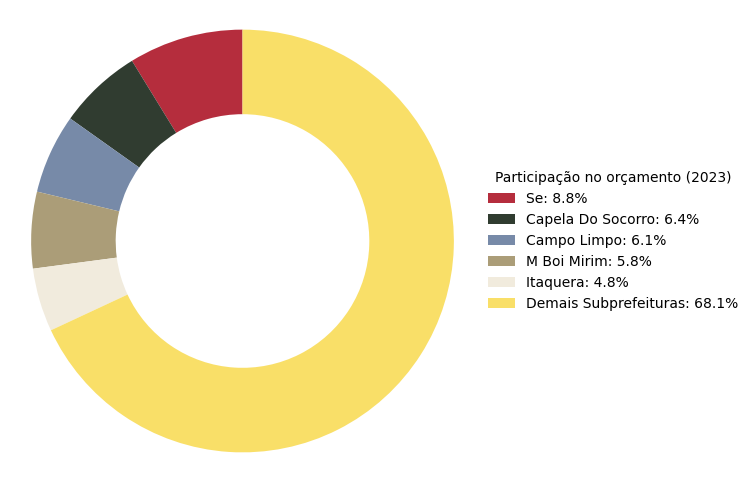

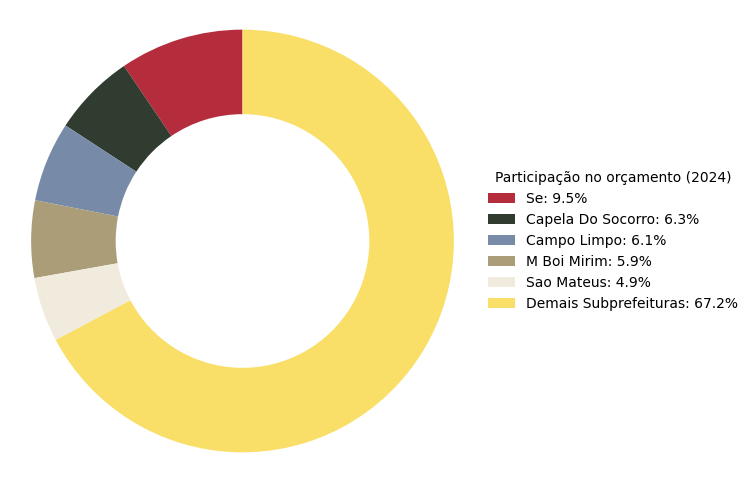

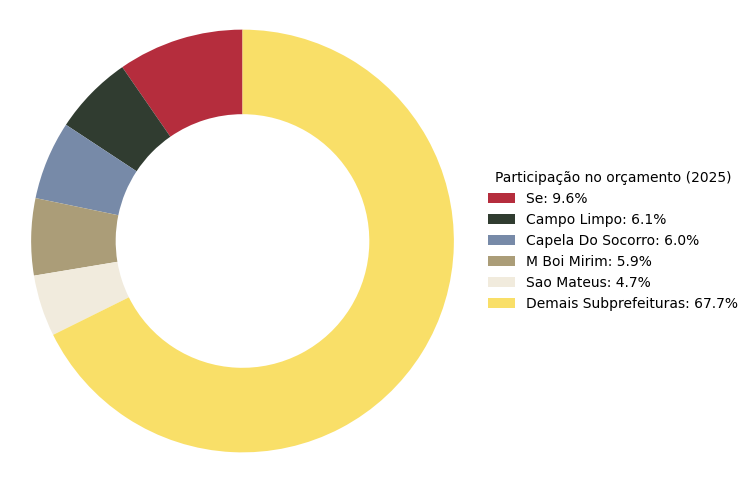

In [5]:
def gerar_pizza_top5(ano):
    df_grouped = df_ppa_reg.groupby("descricao prefeitura regional")[[f"valor {ano}"]].sum().reset_index()
    df_grouped = df_grouped.rename(columns={"descricao prefeitura regional": "nm_subpref"})

    df_grouped["percentual"] = df_grouped[f"valor {ano}"] / df_grouped[f"valor {ano}"].sum() * 100
    df_sorted = df_grouped.sort_values(f"valor {ano}", ascending=False)

    top5 = df_sorted.iloc[:5]
    demais_valor = df_sorted.iloc[5:][f"valor {ano}"].sum()
    demais_pct = df_sorted.iloc[5:][f"valor {ano}"].sum() / df_grouped[f"valor {ano}"].sum() * 100

    plot_df = pd.concat([
        top5[["nm_subpref", f"valor {ano}", "percentual"]],
        pd.DataFrame({"nm_subpref": ["Demais subprefeituras"],
                      f"valor {ano}": [demais_valor],
                      "percentual": [demais_pct]})
    ], ignore_index=True)

    cores = ["#B52D3D", "#303C30", "#778AA8", "#AB9D78", "#F1EBDD", "#F9DF68"]

    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, _ = ax.pie(plot_df[f"valor {ano}"], colors=cores, startangle=90, wedgeprops=dict(width=0.4))

    legenda = [f'{row["nm_subpref"].title()}: {row["percentual"]:.1f}%' for _, row in plot_df.iterrows()]
    legend = ax.legend(wedges, legenda, title=f"Participação no orçamento ({ano})", loc="center left", bbox_to_anchor=(1, 0.5))
    legend.get_frame().set_linewidth(0)

    ax.axis("equal")
    plt.show()

for ano in [2022, 2023, 2024, 2025]:
    gerar_pizza_top5(ano)

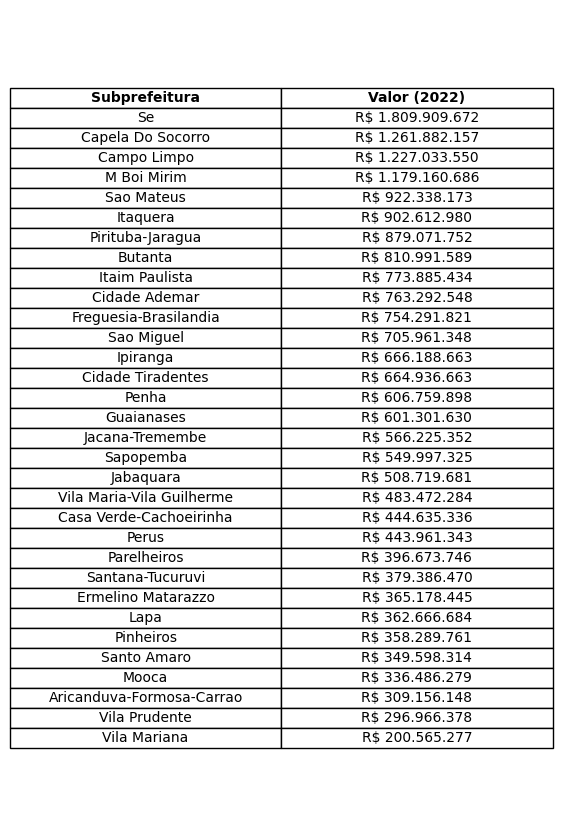

Base salva em data\tabela_orcamento_2022.csv


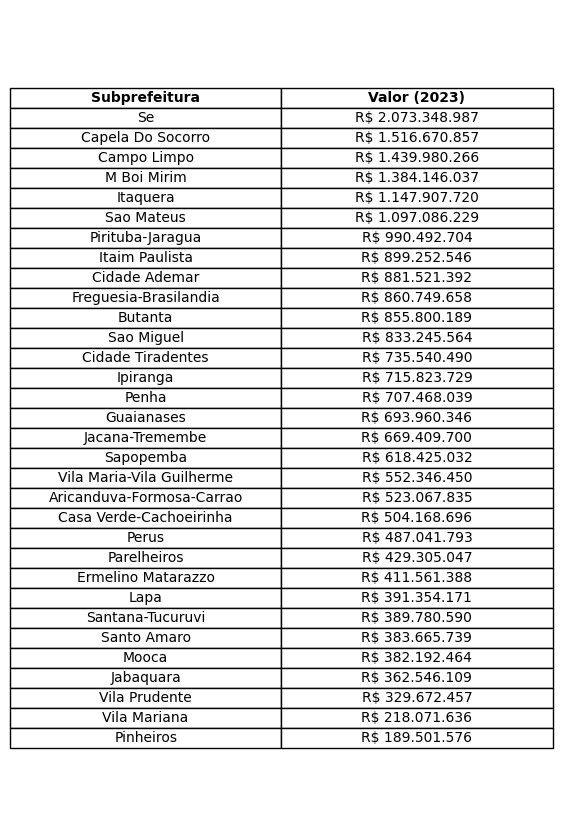

Base salva em data\tabela_orcamento_2023.csv


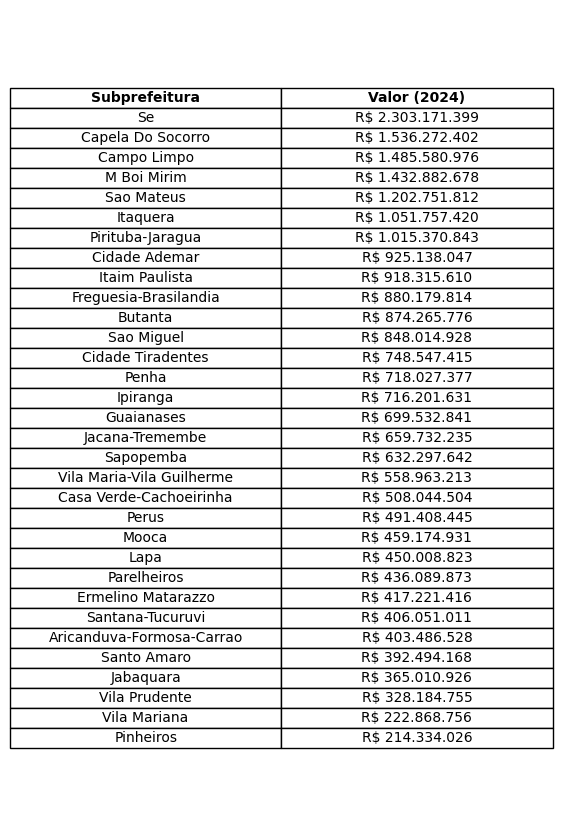

Base salva em data\tabela_orcamento_2024.csv


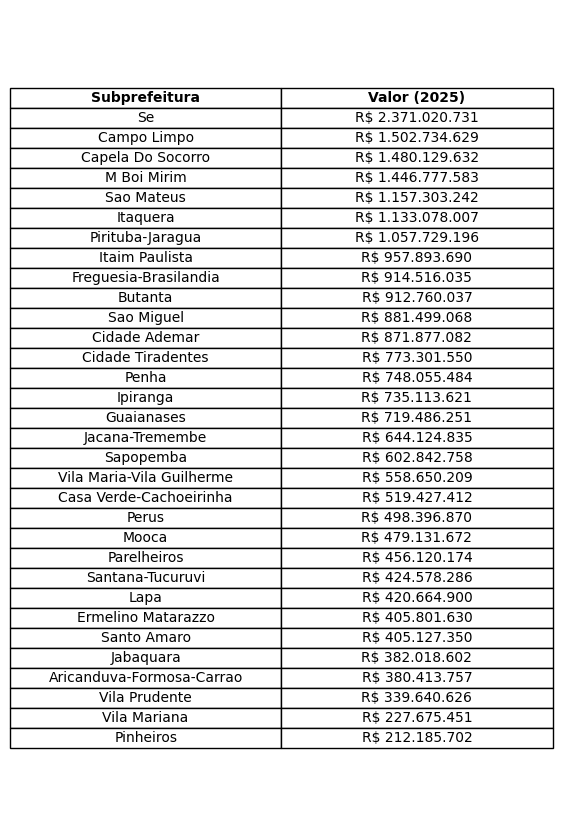

Base salva em data\tabela_orcamento_2025.csv


In [6]:
def gerar_tabela_orcamento(ano):
    df_grouped = df_ppa_reg.groupby("descricao prefeitura regional")[[f"valor {ano}"]].sum().reset_index()
    df_grouped = df_grouped.rename(columns={"descricao prefeitura regional": "nm_subpref"})
    df_grouped = df_grouped.sort_values(f"valor {ano}", ascending=False)

    df_grouped["valor_fmt"] = df_grouped[f"valor {ano}"].apply(lambda x: f"R$ {x:,.0f}".replace(",", "."))

    fig, ax = plt.subplots(figsize=(7, len(df_grouped) * 0.3 + 1))
    ax.axis("off")

    table_data = [[row["nm_subpref"].title(), row["valor_fmt"]] for _, row in df_grouped.iterrows()]
    table = ax.table(cellText=table_data,
                     colLabels=["Subprefeitura", f"Valor ({ano})"],
                     loc="center",
                     cellLoc="left",
                     colLoc="left")

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)

    for i in range(len(table_data)):
        for j in range(2):
            table[(i+1, j)].set_facecolor("white")
            table[(i+1, j)].set_text_props(color="black", ha="center")

    for j in range(2):
        table[(0, j)].set_facecolor("white")
        table[(0, j)].set_text_props(fontweight="bold", ha="center")

    plt.show()

    df_to_save = df_grouped[["nm_subpref", "valor_fmt"]].copy()
    df_to_save.columns = ["Subprefeitura", f"Valor ({ano})"]

    save_csv(df_to_save, f"tabela_orcamento_{ano}.csv")

for ano in [2022, 2023, 2024, 2025]:
    gerar_tabela_orcamento(ano)

#### Visualização 2

In [7]:
pd.set_option("display.max_rows", None)

dfs_top3_por_ano = {}

anos = ["2022", "2023", "2024", "2025"]

for ano in anos:
    df = gdf_merged.copy()
    col_valor = f"valor {ano}"

    df_ano = df[["nm_subpref", "descrica_2", col_valor, "geometry"]].copy()

    top_funcoes = (df_ano.groupby("descrica_2")[[col_valor]]
                          .sum()
                          .reset_index()
                          .sort_values(col_valor, ascending=False)
                          .head(3)["descrica_2"]
                          .tolist())

    df_top3 = df_ano[df_ano["descrica_2"].isin(top_funcoes)]

    df_top3_grouped = (df_top3.groupby(["nm_subpref", "descrica_2"])[[col_valor]]
                                  .sum()
                                  .reset_index())
    
    df_top3_grouped = df_top3_grouped.rename(columns={col_valor: "valor"})
    
    df_top3_grouped["ano"] = ano

    df_top3_grouped = df_top3_grouped[["ano", "nm_subpref", "descrica_2", "valor"]]

    dfs_top3_por_ano[ano] = df_top3_grouped

df_top3_todos_anos = pd.concat(dfs_top3_por_ano.values(), ignore_index=True)

#df_top3_todos_anos["valor"].describe()
#df_top3_todos_anos
#df_ano
#top_funcoes

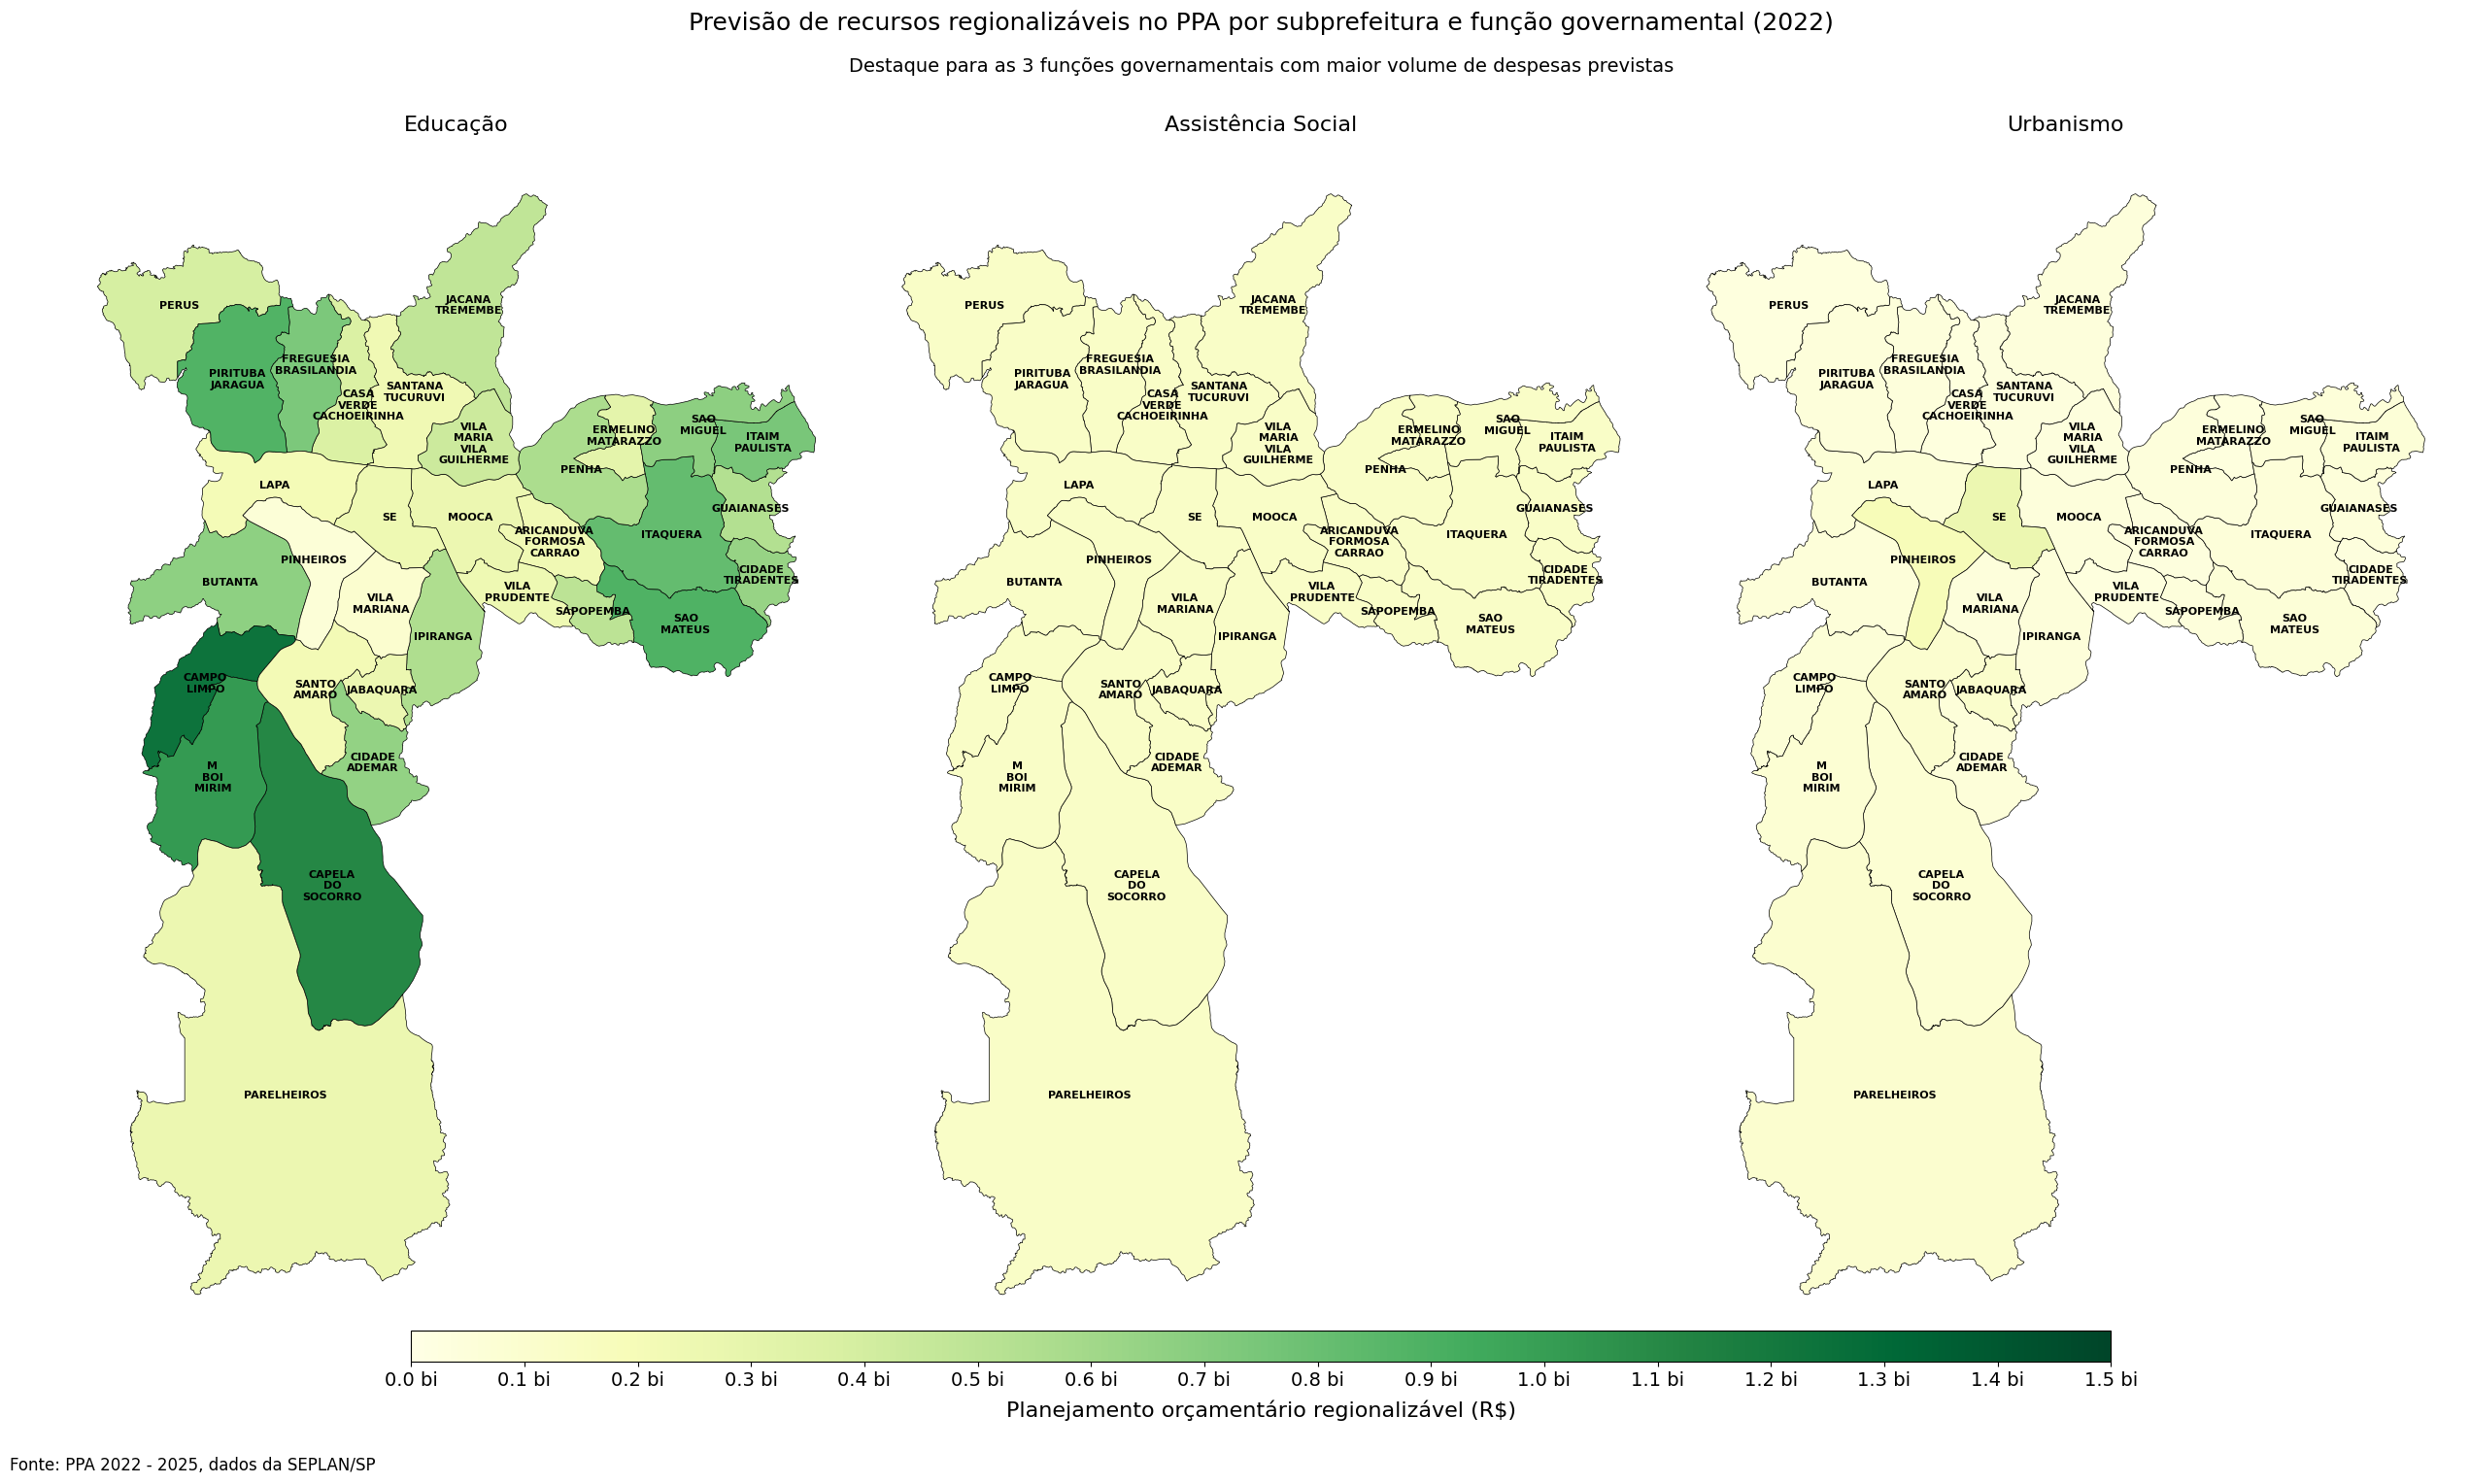

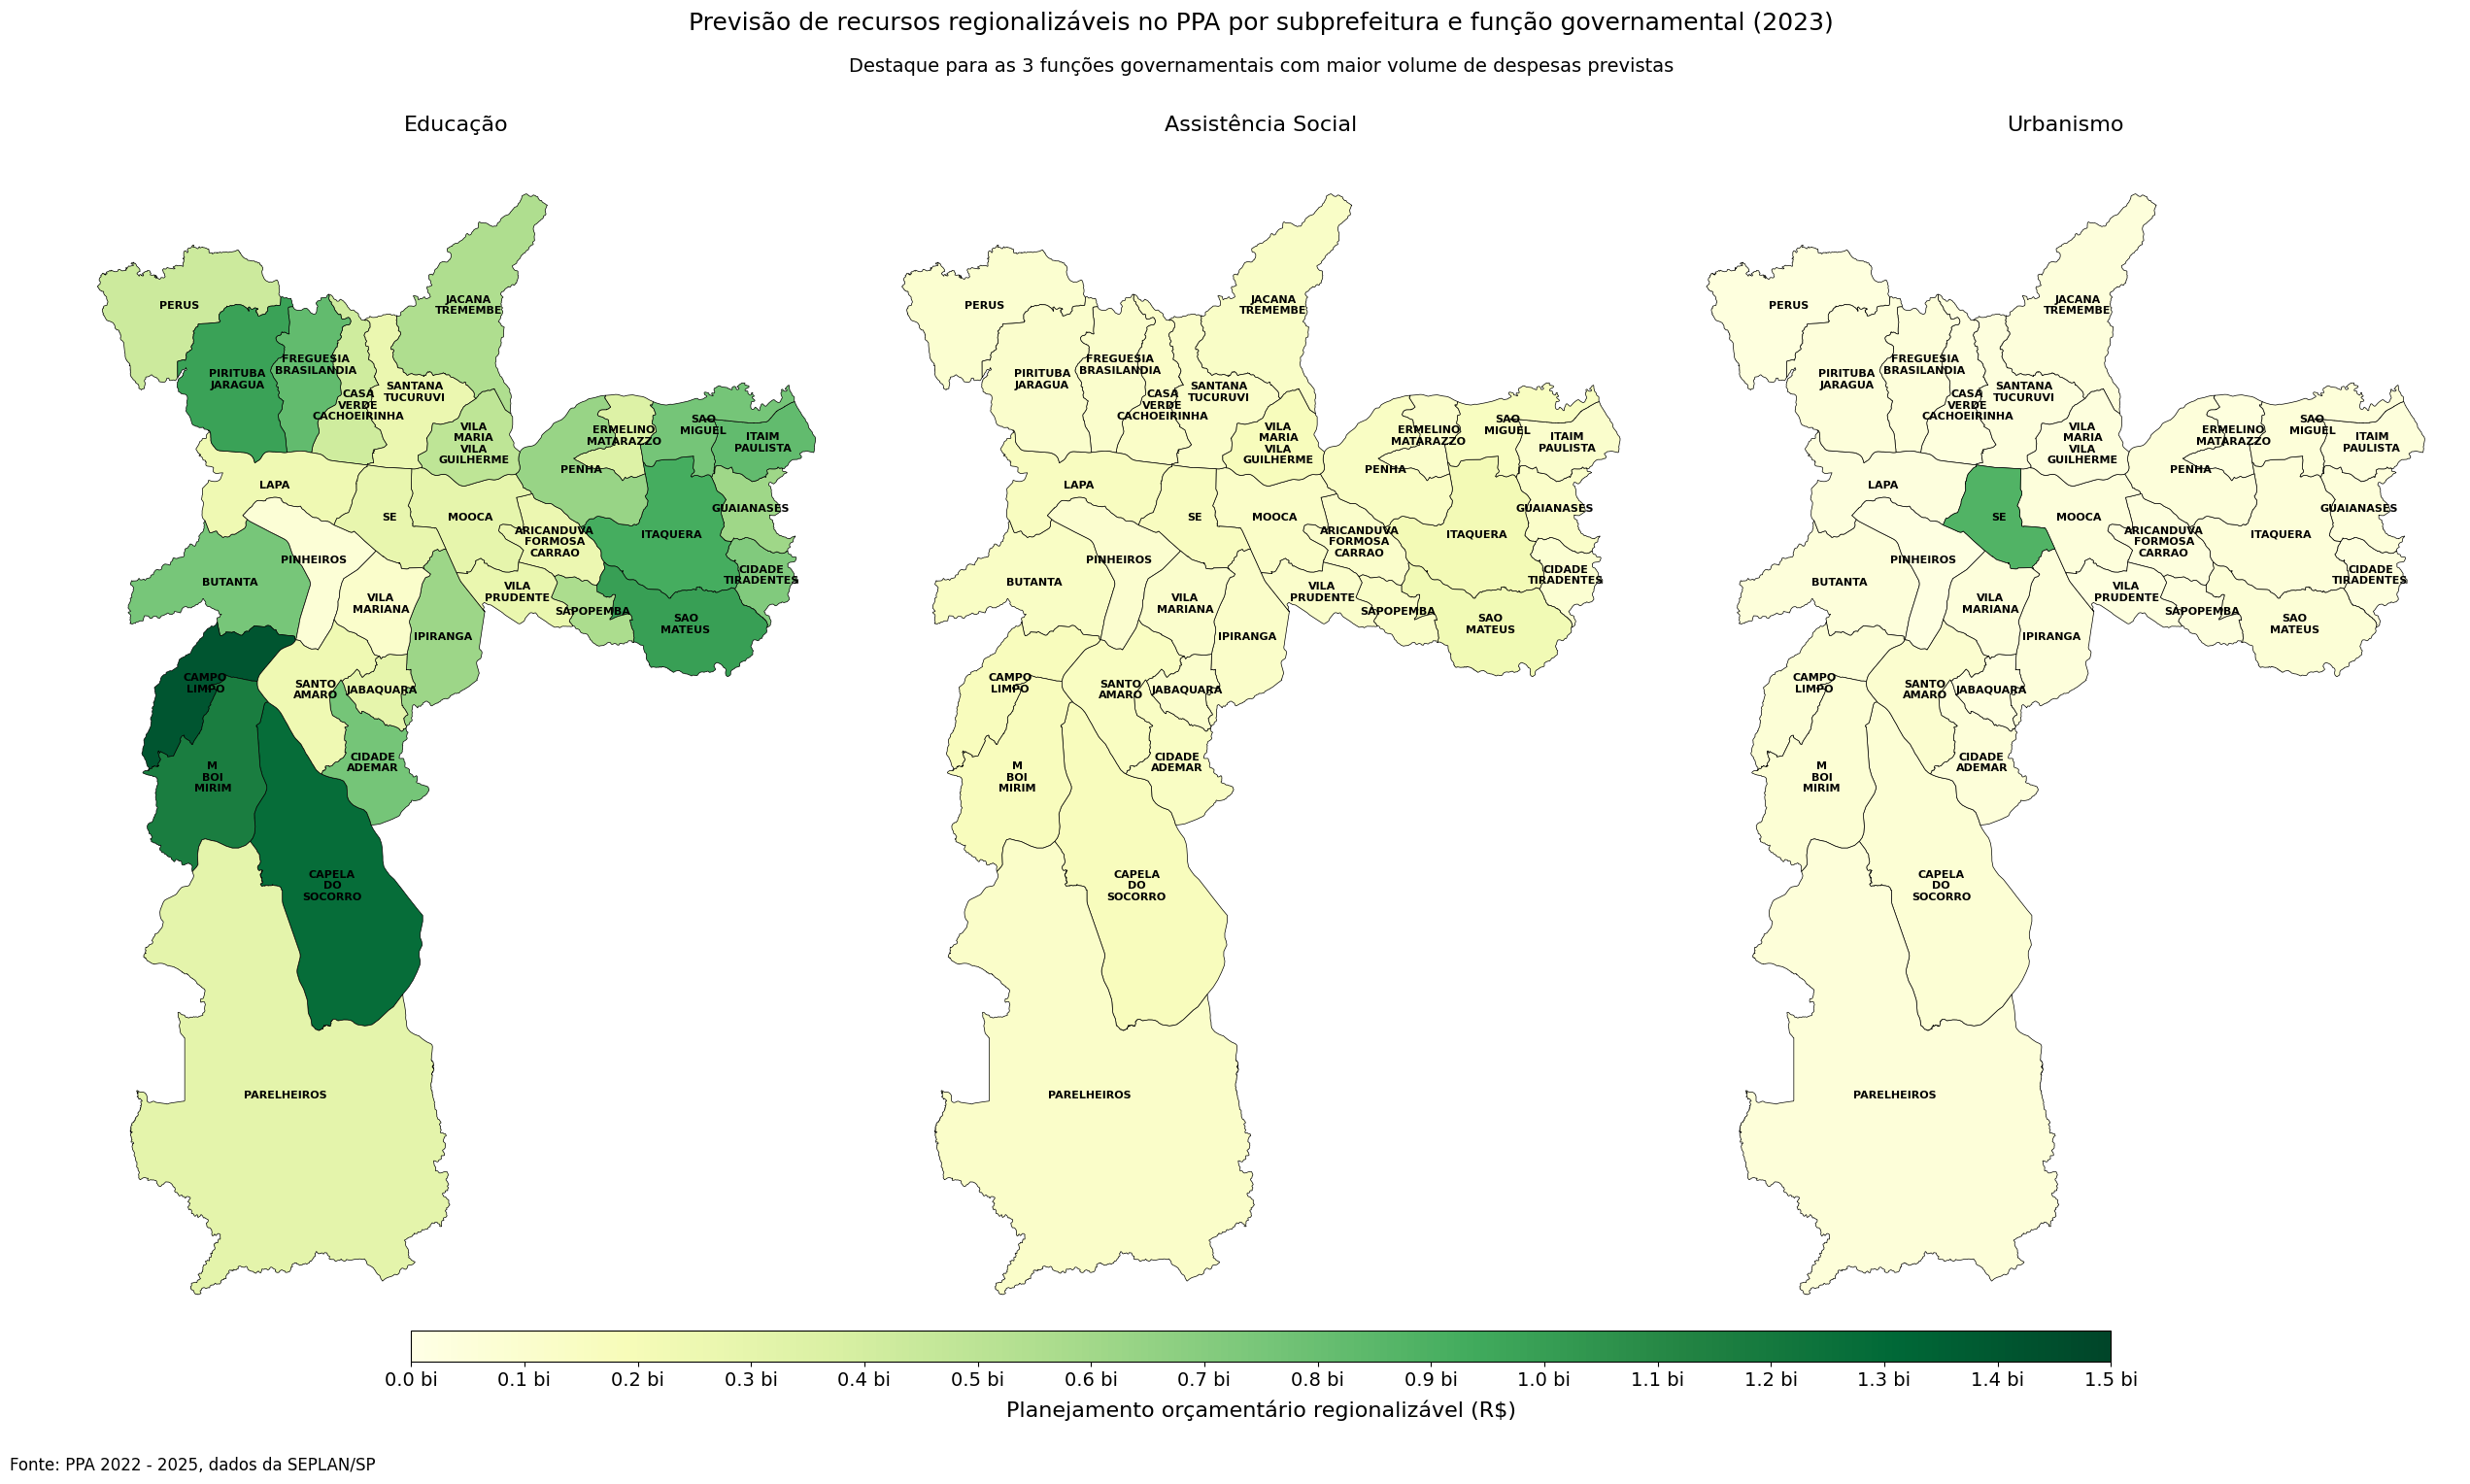

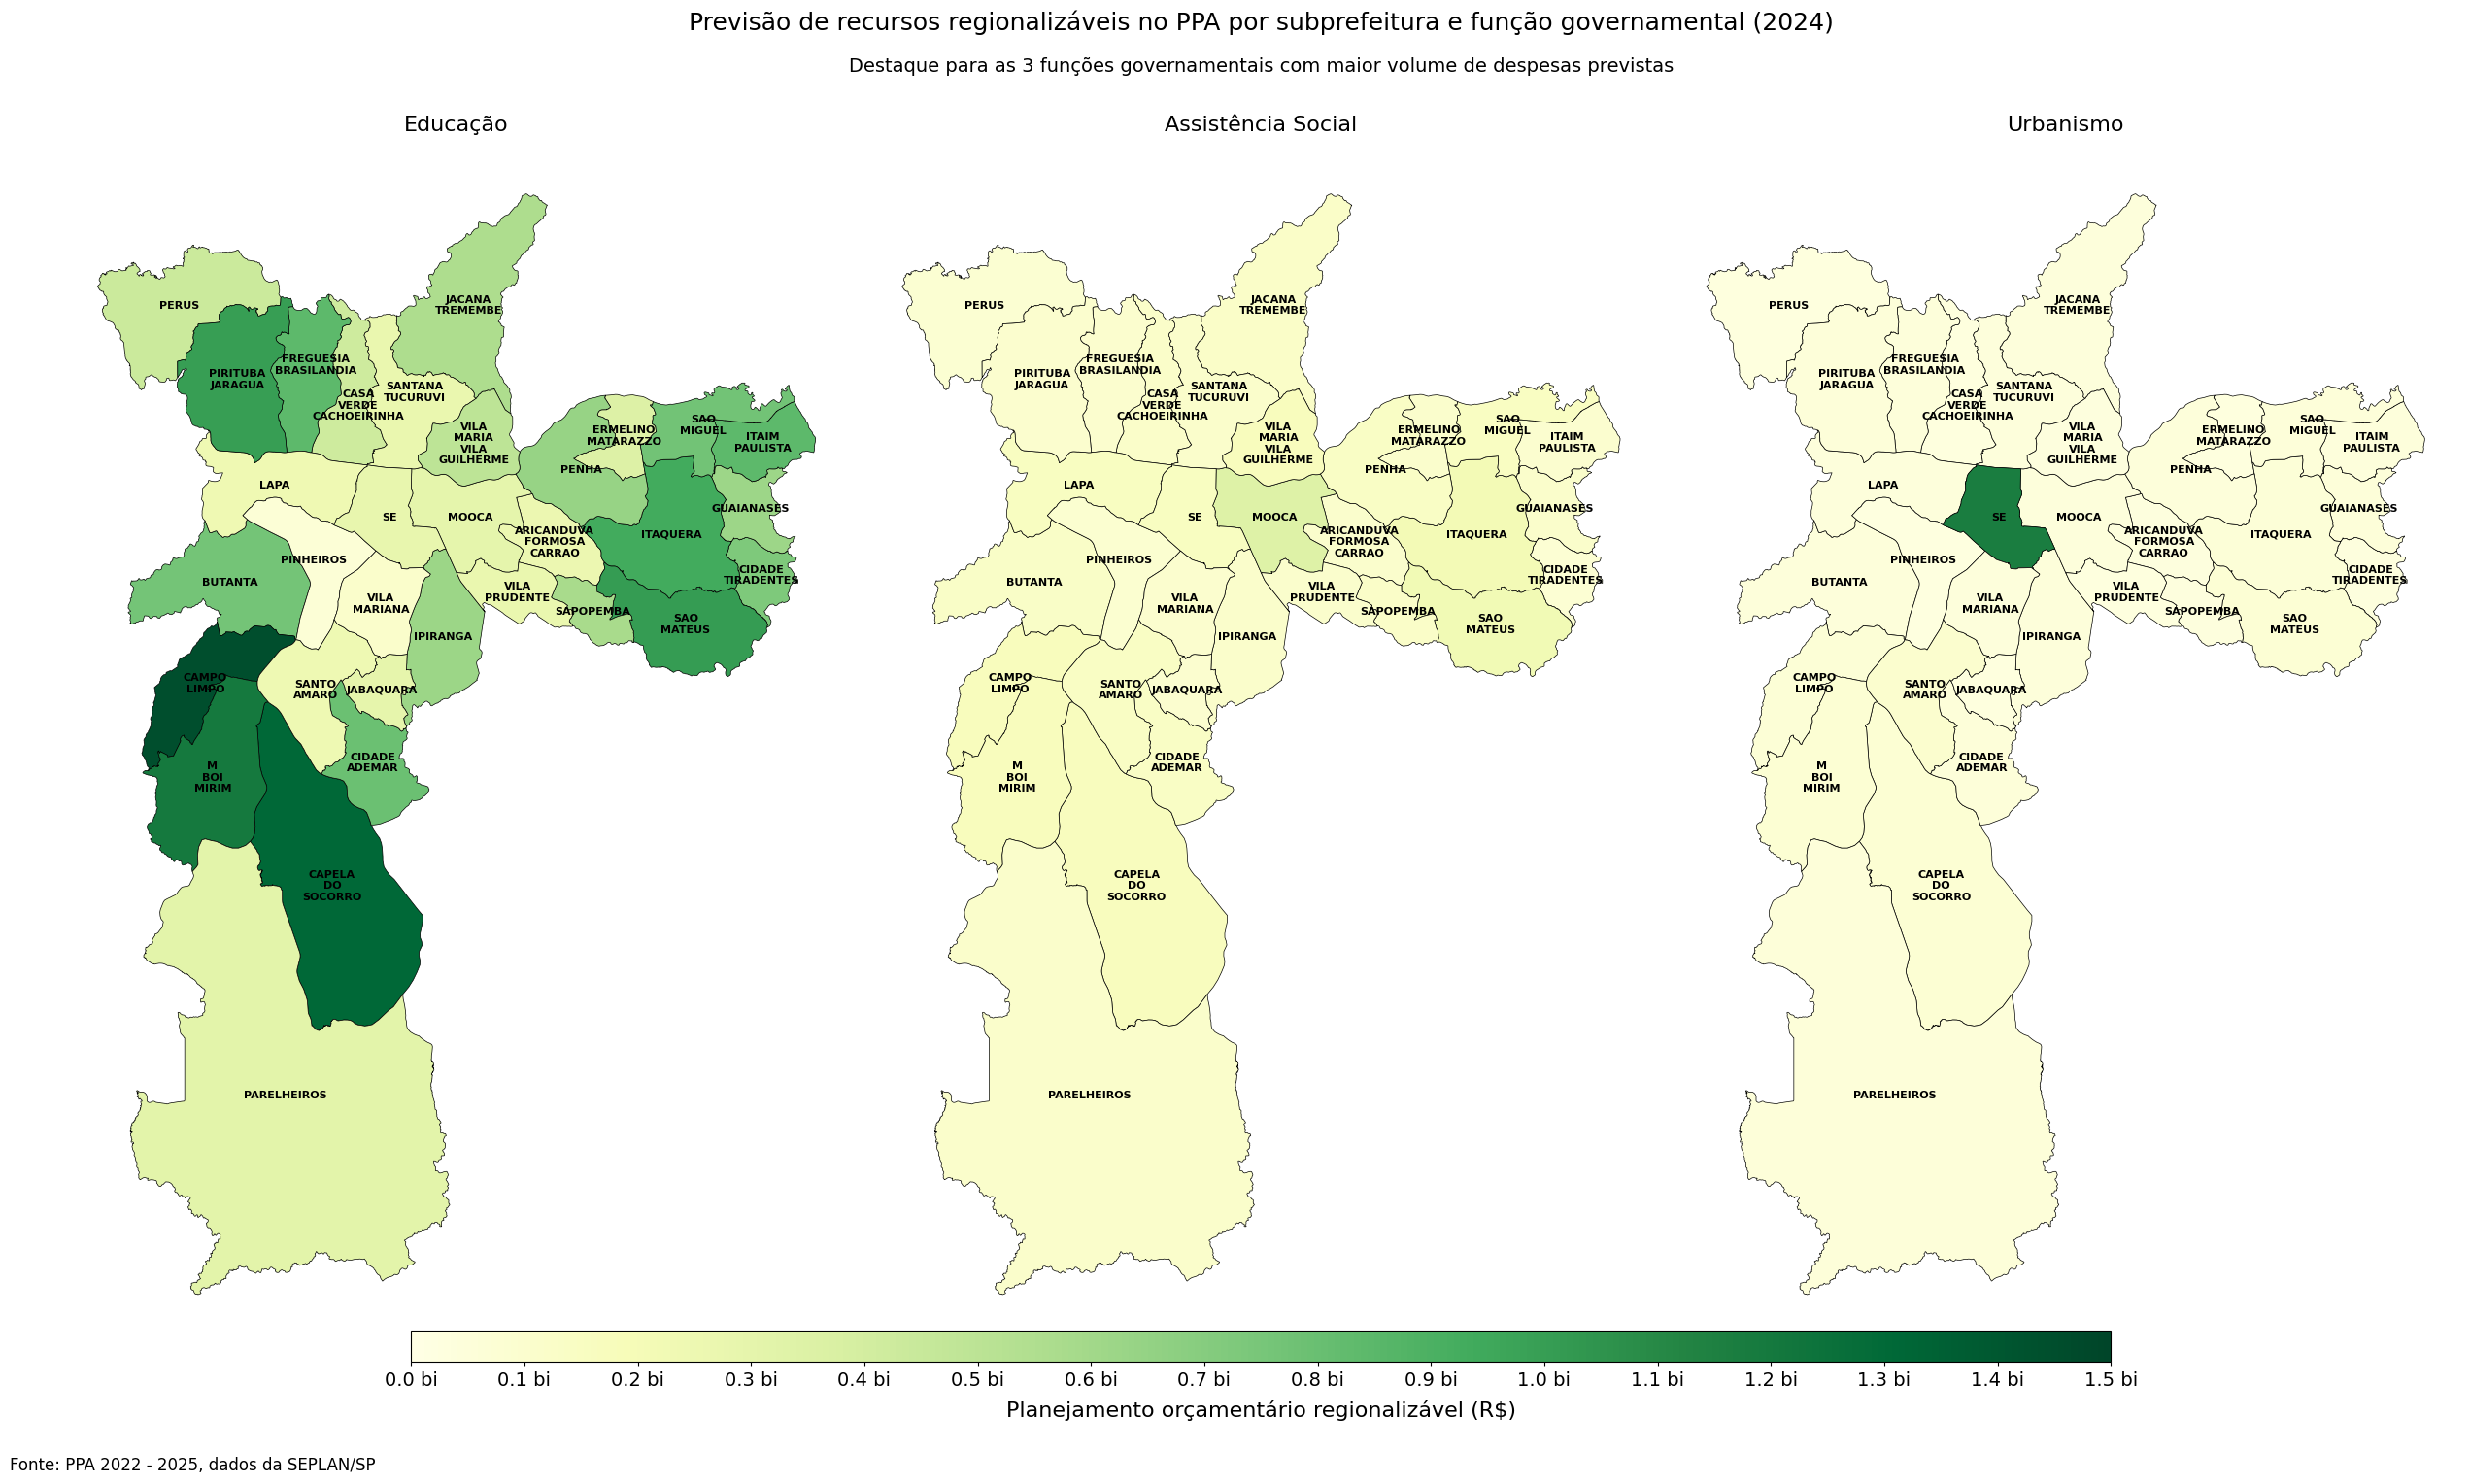

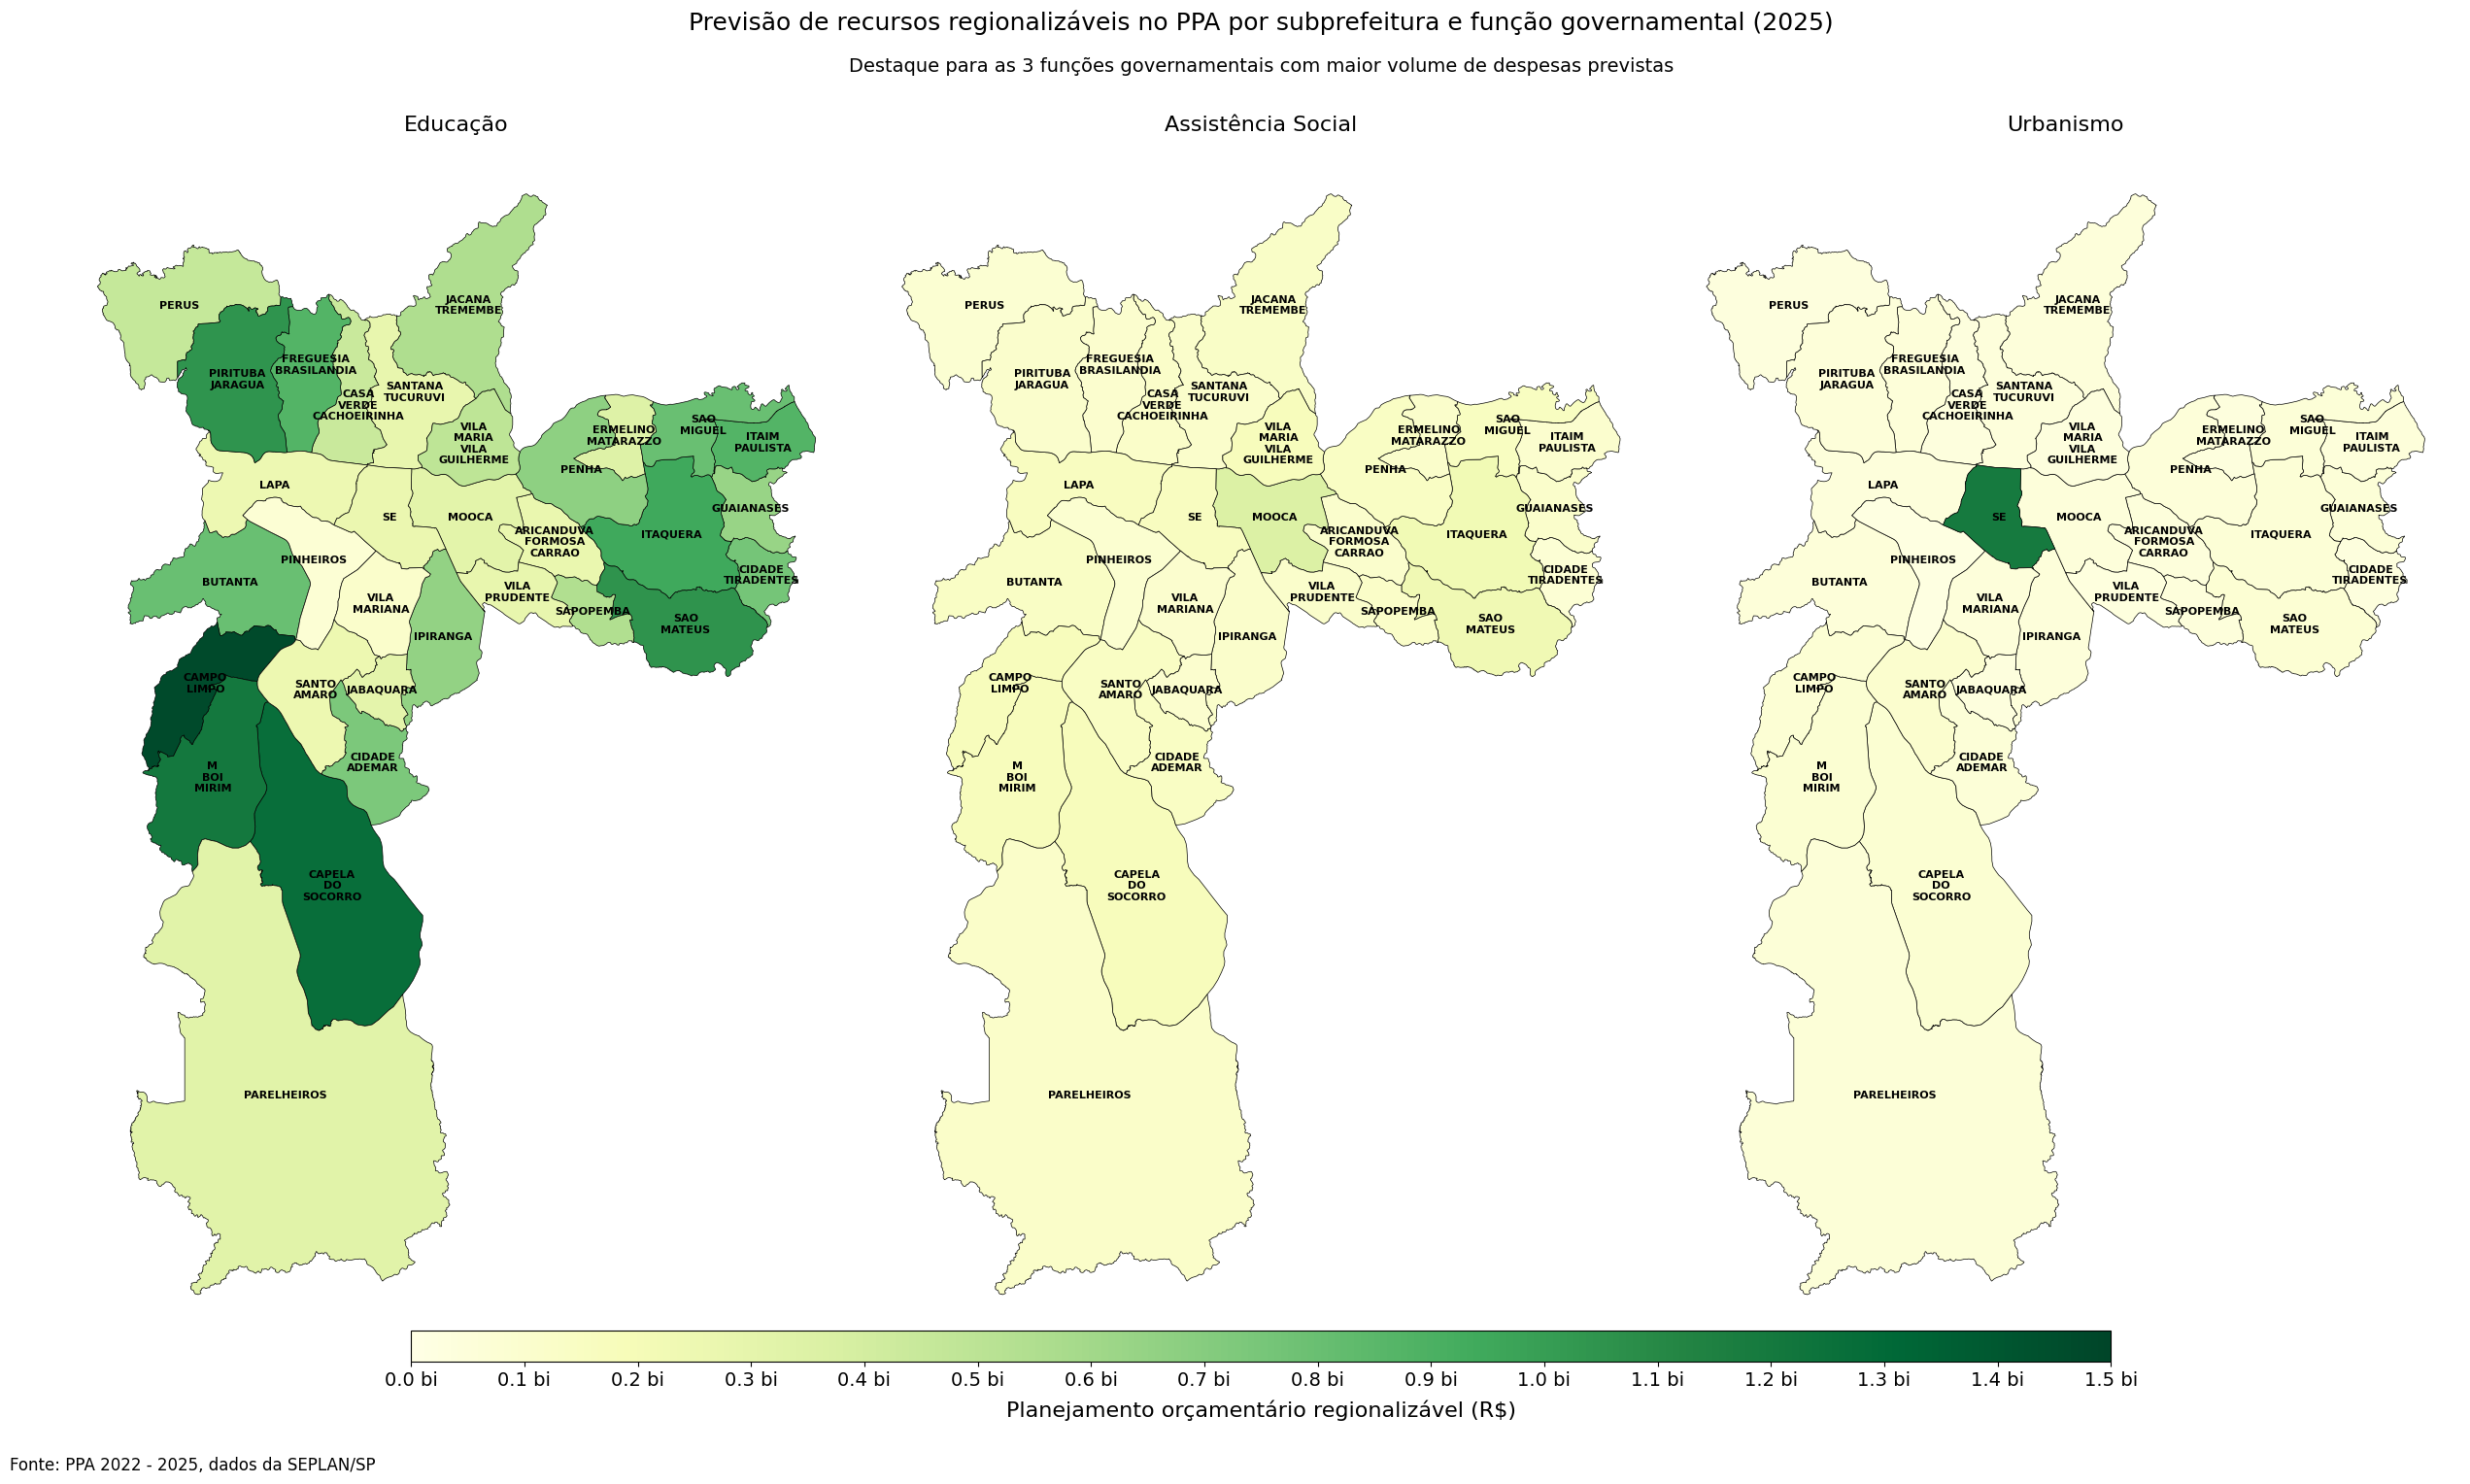

In [8]:
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

vmax_geral = 1.5e9

vmin = 0

anos = ["2022", "2023", "2024", "2025"]

deslocamentos = {"FREGUESIA-BRASILANDIA": (500, 500),
                 "CASA VERDE-CACHOEIRINHA": (500, -500),
                 "SANTANA-TUCURUVI": (500, 500)}

def gerar_top3_funcoes_por_ano(ano, vmax):
    df = gdf_merged.copy()
    col_valor = f"valor {ano}"

    df_ano = df[["nm_subpref", "descrica_2", col_valor, "geometry"]].copy()

    top_funcoes = (df_ano.groupby("descrica_2")[[col_valor]]
                          .sum()
                          .reset_index()
                          .sort_values(col_valor, ascending=False)
                          .head(3)["descrica_2"]
                          .tolist())

    df_top3 = df_ano[df_ano["descrica_2"].isin(top_funcoes)]

    fig, axs = plt.subplots(1, 3, figsize = (25, 16))

    for i, funcao in enumerate(top_funcoes):
        ax = axs[i]

        gdf_plot = df_top3[df_top3["descrica_2"] == funcao]

        gdf_plot = (gdf_plot.groupby(["nm_subpref", "geometry"])[[col_valor]]
                              .sum()
                              .reset_index())

        gdf_plot = gpd.GeoDataFrame(gdf_plot, geometry = "geometry", crs=gdf_merged.crs)

        gdf_plot["centroid"] = gdf_plot.geometry.centroid
        gdf_plot["desloc_x"] = gdf_plot.apply(lambda row: row["centroid"].x + deslocamentos.get(row["nm_subpref"], (0, 0))[0], axis = 1)
        gdf_plot["desloc_y"] = gdf_plot.apply(lambda row: row["centroid"].y + deslocamentos.get(row["nm_subpref"], (0, 0))[1], axis = 1)

        gdf_plot.plot(column = col_valor,
                      cmap = "YlGn",
                      linewidth = 0.5,
                      edgecolor = "black",
                      ax = ax,
                      vmin = vmin,
                      vmax = vmax)

        for _, row in gdf_plot.iterrows():
            nome = "\n".join(row["nm_subpref"].replace("-", " ").split())
            ax.text(row["desloc_x"], row["desloc_y"],
                    nome,
                    fontsize = 8,
                    ha = "center",
                    va = "center",
                    fontweight = "bold",
                    color = "black")

        ax.set_title(f"{funcao}", fontsize=16)
        ax.axis("off")

    cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
    sm = plt.cm.ScalarMappable(cmap = "YlGn", norm = plt.Normalize(vmin = vmin, vmax = vmax))
    sm._A = []
    cbar = fig.colorbar(sm, cax = cbar_ax, orientation = "horizontal")
    cbar.set_label("Planejamento orçamentário regionalizável (R$)", fontsize = 16, labelpad = 8)

    ticks = [i * 100e6 for i in range(16)]
    cbar.set_ticks(ticks)
    cbar.ax.tick_params(labelsize = 14)
    cbar.ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1e9:.1f} bi'))

    fig.suptitle(f"Previsão de recursos regionalizáveis no PPA por subprefeitura e função governamental ({ano})",
                 fontsize = 18, y = 0.95)
    
    fig.text(0.5, 0.91, "Destaque para as 3 funções governamentais com maior volume de despesas previstas", 
             ha = "center", fontsize = 14)

    plt.figtext(0.06, 0.01, "Fonte: PPA 2022 - 2025, dados da SEPLAN/SP", ha = "center", fontsize = 12)
    plt.tight_layout(rect = [0, 0.05, 1, 0.93])
    plt.show()

    save_graph(fig, f"interativo_2_{ano}.png")

for ano in anos:
    gerar_top3_funcoes_por_ano(ano, vmax = vmax_geral)